# Dependencies and setup

In [23]:
import cv2
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, metrics, model_selection

from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout

np.random.seed(2019)
data_dir = os.path.join('..', 'Data', 'Training')

# Read all the data into memory

In [24]:
# Get a list of all the data files
data_files = glob.glob(os.path.join(data_dir, '*.png'))

# Read the first image to get the size
test_img = cv2.imread(data_files[0])
img_size = test_img.shape[0:2]

# Initialize data elements (avoids resizing later)
X = np.zeros((len(data_files), img_size[0], img_size[1]))
y = np.zeros(len(data_files))

# Step through all the files
current_idx = 0;
for fs in data_files:
    # Parse the filename (we only really care about extracting the object class)
    x = re.search("\d+\.\d+\.(\S+)\.png", fs)
    
    # Read the file
    img = cv2.imread(fs)
    img = np.squeeze(img[:,:,1]) # select the first color channel
    
    if (x.group(1) == '1'): # "Car"
        X[current_idx,:,:] = img
        y[current_idx] = 1
        current_idx += 1
    elif(x.group(1) == 'bg'): # Background
        X[current_idx,:,:] = img
        y[current_idx] = 0
        current_idx += 1

num_cars = np.count_nonzero(y==1)
num_bg = np.count_nonzero(y==0)
print("found {} cars and {} background images".format(num_cars, num_bg))

# Equalize the class probabilities for training (delete a random subset)
# We do this now and not earlier because we don't know fully what we are going to get out of the directory apriori
num_bg_to_delete = num_bg-num_cars
if (num_bg_to_delete):
    print("Deleting ", num_bg_to_delete, " background images")
    bg_idx = np.nonzero(y==0)[0]
    np.random.shuffle(bg_idx)
    to_delete = bg_idx[0:num_bg_to_delete]
    y = np.delete(y,to_delete)
    X = np.delete(X,to_delete, axis=0)
    
num_cars = np.count_nonzero(y==1)
num_bg = np.count_nonzero(y==0)
print("After class equalization, there are {} cars and {} background images".format(num_cars, num_bg))
print(X.shape)

found 852 cars and 5014 background images
Deleting  4162  background images
After class equalization, there are 852 cars and 852 background images
(1704, 64, 64)


<function matplotlib.pyplot.show(*args, **kw)>

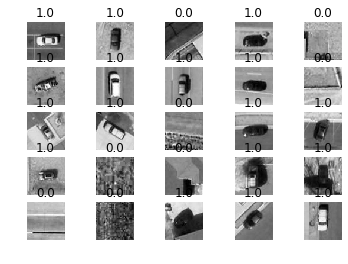

In [25]:
imgs_to_show = 25
imgs_per_col = 5
for i in range(0, imgs_to_show):
    plt.subplot(imgs_to_show/imgs_per_col, imgs_per_col, i+1)
    plt.imshow(X[i,:,:], cmap='gray')
    plt.axis('off')
    plt.title(y[i])
plt.show

# Classification setup

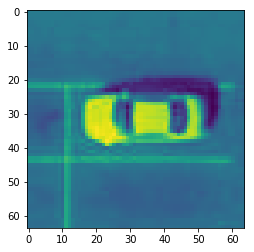

In [26]:
X_float = X.astype('float32')
X_float /= 255

plt.imshow(X[0,:,:])
plt.show()

# SVM Classifier

In [31]:
X_flat = X.reshape((len(X), -1))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_flat, y, test_size=0.25, random_state=23)

In [32]:
parameters = [
    {'kernel':['rbf'], 'gamma':np.logspace(-10, -4, 10)}
    #{'kernel':['linear'], 'C':np.logspace(-5, 4, 20)}
]
clf=svm.SVC()
cv_clf=model_selection.GridSearchCV(estimator=clf, param_grid=parameters, cv=4, n_jobs=-1);
cv_clf.fit(X_train,y_train)
print("Best estimator:\n", cv_clf.best_estimator_)

#Check performance
y_pred = cv_clf.predict(X_test)

print("Accuracy score:\n", metrics.accuracy_score(y_test,y_pred))

Best estimator:
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2.1544346900318822e-07,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Accuracy score:
 0.9507042253521126


# CNN

In [5]:
X_for_cnn = X_float
x_train, x_test, y_train, y_test = model_selection.train_test_split(X.reshape(X_for_cnn.shape[0], X_for_cnn.shape[1], X_for_cnn.shape[2], 1), y, test_size=0.25, random_state=23)
input_shape = (x_train.shape[1], x_train.shape[2], 1)

In [6]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(4,4)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=3)

Epoch 1/3
1278/1278 [==============================] - 3s 3ms/sample - loss: 0.5299 - acc: 0.7966
Epoch 2/3
1278/1278 [==============================] - 3s 3ms/sample - loss: 0.1858 - acc: 0.9249
Epoch 3/3
1278/1278 [==============================] - 3s 3ms/sample - loss: 0.0998 - acc: 0.9679


In [8]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18010428673784498
Test accuracy: 0.9366197


Guessed  1  was  0.0  probs [0.39445108 0.6055489 ]


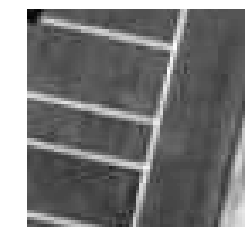

Guessed  0  was  1.0  probs [0.8165371  0.18346293]


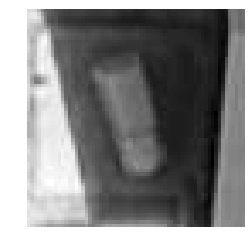

Guessed  1  was  0.0  probs [0.4948597  0.50514036]


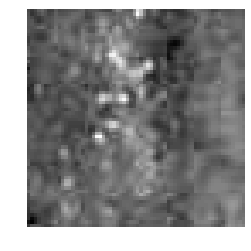

Guessed  1  was  0.0  probs [0.21164565 0.7883544 ]


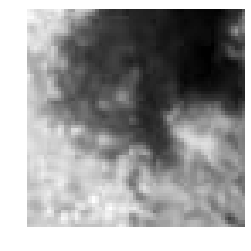

Guessed  1  was  0.0  probs [0.14930111 0.8506989 ]


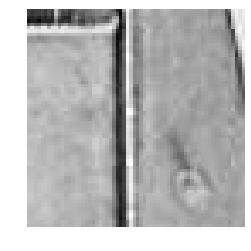

Guessed  1  was  0.0  probs [0.3478109  0.65218914]


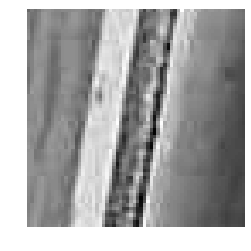

Guessed  1  was  0.0  probs [9.794310e-04 9.990206e-01]


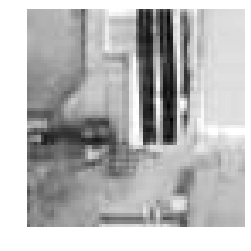

Guessed  0  was  1.0  probs [0.64360803 0.356392  ]


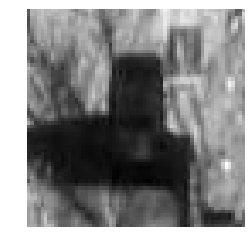

Guessed  1  was  0.0  probs [0.05804285 0.9419572 ]


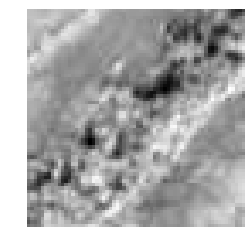

Guessed  1  was  0.0  probs [0.46762958 0.5323704 ]


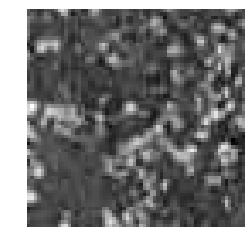

Guessed  0  was  1.0  probs [0.9089455  0.09105449]


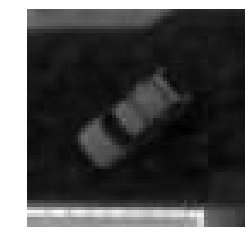

Guessed  1  was  0.0  probs [0.49210694 0.5078931 ]


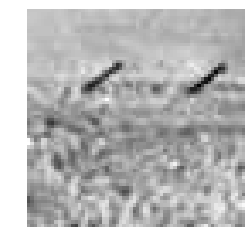

Guessed  1  was  0.0  probs [0.48737466 0.5126254 ]


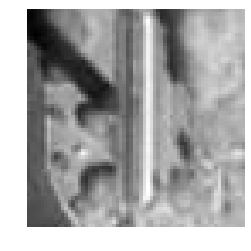

Guessed  1  was  0.0  probs [0.26291415 0.7370858 ]


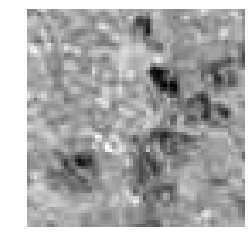

Guessed  1  was  0.0  probs [0.38905945 0.6109406 ]


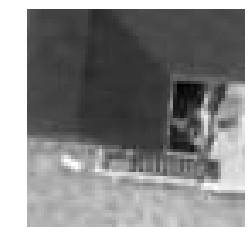

Guessed  0  was  1.0  probs [0.8444283 0.1555717]


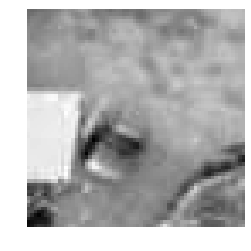

Guessed  1  was  0.0  probs [0.4859425 0.5140576]


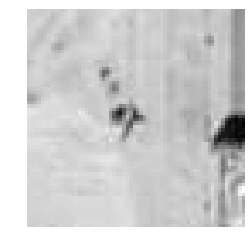

Guessed  1  was  0.0  probs [0.17946658 0.82053345]


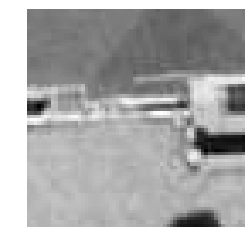

Guessed  1  was  0.0  probs [0.37084958 0.6291504 ]


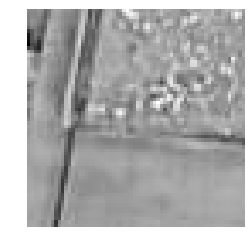

Guessed  1  was  0.0  probs [0.10517538 0.8948247 ]


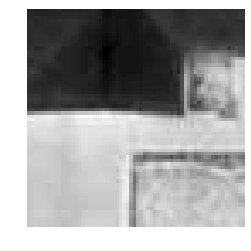

Guessed  1  was  0.0  probs [0.4545547 0.5454453]


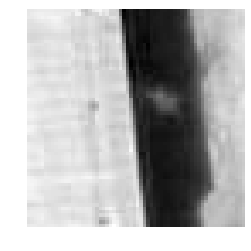

Guessed  1  was  0.0  probs [0.19946052 0.80053943]


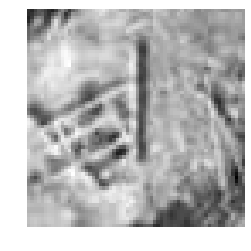

Guessed  1  was  0.0  probs [0.3397986 0.6602014]


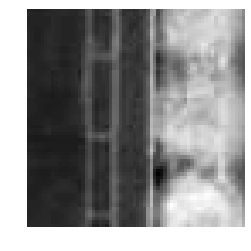

Guessed  1  was  0.0  probs [0.15195867 0.84804136]


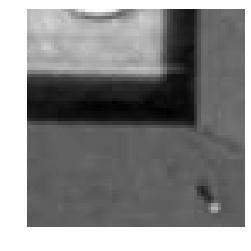

Guessed  1  was  0.0  probs [0.44068494 0.5593151 ]


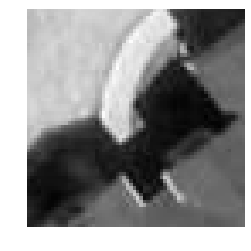

Guessed  1  was  0.0  probs [0.47860324 0.52139676]


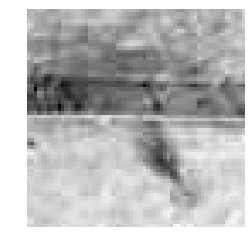

Guessed  1  was  0.0  probs [0.03620606 0.96379393]


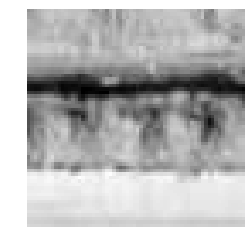

In [9]:
y_hat = model.predict(x_test)
for i in range(0, len(y_test)):
    if np.argmax(y_hat[i,:]) != y_test[i]:
        print("Guessed ", np.argmax(y_hat[i,:]), " was ", y_test[i], " probs", y_hat[i,:])
        plt.imshow(np.squeeze(x_test[i,:,:,:]), cmap='gray');
        plt.axis('off')
        plt.show()

# Transfer learning from ResNet50
[Kaggle Example](https://www.kaggle.com/dansbecker/transfer-learning)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1704, 64, 64, 3)


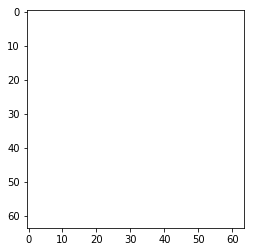

In [27]:
X_color = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X_color = np.tile(X_color, (1,1,1,3))
X_color /= 3
print(X_color.shape)
plt.imshow(X_color[0,:,:,:])
plt.show()
                  
x_train, x_test, y_train, y_test = model_selection.train_test_split(X_color, y, test_size=0.25, random_state=23)
input_shape = (x_train.shape[1], x_train.shape[2], 3)

In [28]:
transfer_model = Sequential()
transfer_model.add(ResNet50(include_top=False, input_shape=input_shape, pooling='avg', weights='imagenet'))
transfer_model.add(Dense(2,activation='softmax'))
transfer_model.layers[0].trainable = False

In [29]:
transfer_model.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
transfer_model.fit(x=x_train,y=y_train, epochs=3)

Epoch 1/3
1278/1278 [==============================] - 8s 7ms/sample - loss: 0.4020 - acc: 0.8482
Epoch 2/3
1278/1278 [==============================] - 9s 7ms/sample - loss: 0.1969 - acc: 0.9304
Epoch 3/3
1278/1278 [==============================] - 11s 8ms/sample - loss: 0.1309 - acc: 0.9554


In [30]:
score = transfer_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2753665914383013
Test accuracy: 0.91784036
